## Installation via conda

1.conda create --name gwr python=3.6 matplotlib numpy pandas scipy jupyter jupyterlab

2.conda install --name gwr fiona=1.8.13

3.conda install --name gwr geopandas=0.8.1

4.conda install -c conda-forge --name gwr libpysal spglm esda maplcassify

5.conda install -c conda-forge --name gwr mgwr 

In [ ]:
import numpy as np
import pandas as pd
import libpysal as ps
import esda
import mapclassify as mc

import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

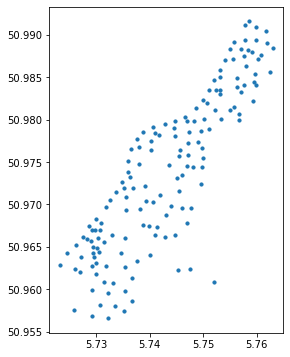

In [4]:
#Load dataset and generate plot of properties 
meuse = gp.read_file(r'...')

fig, ax = plt.subplots(figsize = (6, 6))
meuse.plot(ax = ax, markersize = 10, marker='o')
plt.show()

In [5]:
print(meuse.head(3))
meuse.dtypes

        x       y  cadmium  copper  lead  zinc   elev      dist    om  ffreq  \
0  181072  333611     11.7      85   299  1022  7.909  0.001358  13.6      1   
1  181025  333558      8.6      81   277  1141  6.983  0.012224  14.0      1   
2  181165  333537      6.5      68   199   640    7.8  0.103029  13.0      1   

   soil  lime landuse  dist_m   POINT_X    POINT_Y  eleve  \
0     1     1      Ah      50  5.758534  50.991562   7909   
1     1     1      Ah      30  5.757861  50.991088   6983   
2     1     1      Ah     150  5.759854  50.990893     78   

                   geometry  
0  POINT (5.75853 50.99156)  
1  POINT (5.75786 50.99109)  
2  POINT (5.75985 50.99089)  


x              int64
y              int64
cadmium      float64
copper         int64
lead           int64
zinc           int64
elev          object
dist         float64
om           float64
ffreq          int64
soil           int64
lime           int64
landuse       object
dist_m         int64
POINT_X      float64
POINT_Y      float64
eleve          int64
geometry    geometry
dtype: object

In [6]:
meuse['elev'] = meuse['elev'].astype(float)

In [7]:
meuse = meuse[['zinc','elev','dist','om', 'POINT_X','POINT_Y','geometry']]
print(meuse.head(2))
print(meuse.dtypes)

   zinc   elev      dist    om   POINT_X    POINT_Y                  geometry
0  1022  7.909  0.001358  13.6  5.758534  50.991562  POINT (5.75853 50.99156)
1  1141  6.983  0.012224  14.0  5.757861  50.991088  POINT (5.75786 50.99109)
zinc           int64
elev         float64
dist         float64
om           float64
POINT_X      float64
POINT_Y      float64
geometry    geometry
dtype: object


In [8]:
# Split data into calibration (train) and prediction (test) sets

train=meuse.sample(frac=0.8,random_state=200) #random state is a seed value
test=meuse.drop(train.index)

print(train.shape)
print(test.shape)

(124, 7)
(31, 7)


In [10]:
#Prepare dataset inputs
#Train
cal_y = train['zinc'].values.reshape((-1, 1)) 
cal_X = train[['elev','dist', 'om']].values

u = train['POINT_X']
v = train['POINT_Y']
cal_coords = list(zip(u, v))

#Test
pred_y = test['zinc'].values.reshape((-1, 1))
pred_X = test[['elev','dist', 'om']].values

y = test['POINT_X']
z = test['POINT_Y']
p_coords = list(zip(y, z))
pred_coords = np.array(p_coords)

In [11]:
# Bandwidth Selection 

#Instantiate bandwidth selection object
selector = Sel_BW(cal_coords, cal_y, cal_X, spherical = True)

#Default golden section search using AICc criterion
bw = selector.search()
print(bw)

49.0


In [12]:
#Fit GWR model
model = GWR(cal_coords, cal_y, cal_X, bw)
gwr_results = model.fit()
#Global  diagnostics
print(gwr_results.resid_ss)
print(gwr_results.aic)
print(gwr_results.aicc)
print(gwr_results.R2)

#Make predictions
pred_results = model.predict(pred_coords, pred_X)

#Check correlation between known and predicted values
corr = np.corrcoef(pred_results.predictions.flatten(),pred_y.flatten())[0][1]
print('correlation between known and predicted values of test dataset',corr)

2223494.9421519563
1607.7296368803052
1616.4833680020845
0.8671056832570114
correlation between known and predicted values of test dataset 0.8765611238085893


In [14]:
#Calculation of TEST ERROR 
test['predictions']=pred_results.predictions.flatten()
test['pred_y']=pred_y.flatten()
test['test_res']=test['pred_y']-test['predictions']

def rmse(x):
    return np.sqrt(((x) ** 2).mean())

rmse_test = rmse(test['test_res'])
print("rmse error of test data is: " + str(rmse_test))
print(test.shape)

rmse error of test data is: 177.80282692378557
(31, 10)


In [15]:
# Model fit all data!
#Prepare dataset inputs

m_y = meuse['zinc'].values.reshape((-1, 1)) 
m_X = meuse[['elev','dist', 'om']].values

a = meuse['POINT_X']
b = meuse['POINT_Y']
m_coords = list(zip(a, b))

In [16]:
# Bandwidth Selection 

#Instantiate bandwidth selection object
selector1 = Sel_BW(m_coords, m_y, m_X, spherical = True)

#Default golden section search using AICc criterion
bw1 = selector1.search()
print(bw1)

50.0


In [17]:
#Fit GWR model
model_all = GWR(m_coords, m_y, m_X, bw1)
gwr_results1 = model_all.fit()

#Global  diagnostics
print(gwr_results1.resid_ss)
print(gwr_results1.aic)
print(gwr_results1.aicc)
print(gwr_results1.R2)

meuse['res'] = gwr_results1.resid_response
rmse_all = rmse(meuse['res'])
print("rmse error of model all data is: " + str(rmse_all), '(this is the training error to be used in the paper)')
print(meuse.shape)

2805394.718084933
2008.7869130286424
2018.5858476283292
0.8648031703038416
rmse error of model all data is: 134.53371607830607 (this is the training error to be used in the paper)
(155, 8)


In [19]:
# Inference on Individual Parameter Estimates

# hypothesis tests for significance of parameter estimates
#default behavior using corrected alpha
filter_t = gwr_results1.filter_tvals()

# estimated coefficients & significance for elev
meuse['elev_params'] = gwr_results1.params[:, 1] #coeff of elev
meuse['elev_params_stand']=  meuse['elev_params'] * ( meuse['elev'].std()/ meuse['zinc'].std())  
# standardised coeff of elev
print ('mean absolute standardised of elev parameters',meuse['elev_params_stand'].apply(abs).mean())
#  mean absolute standardised coeff of elev

meuse['elev_t'] = filter_t[:, 1]
insig_elev = meuse[meuse['elev_t']> 0.05]['elev_t']
print ('number of elev insigificant parameters', len(insig_elev.index))

# estimated coefficients & significance for dist
meuse['dist_params'] = gwr_results1.params[:, 2] #params = n*k, estimated coefficients
meuse['dist_params_stand']=  meuse['dist_params'] * ( meuse['dist'].std()/ meuse['zinc'].std())  
print ('mean absolute standardised of dist parameters',meuse['dist_params_stand'].apply(abs).mean())

meuse['dist_t'] = filter_t[:, 2]
insig_dist = meuse[meuse['dist_t']> 0.05]['dist_t']
print ('number of dist insigificant parameters', len(insig_dist.index))

# estimated coefficients & significance for om
meuse['om_params'] = gwr_results1.params[:, 3]
meuse['om_params_stand']=  meuse['om_params'] * ( meuse['om'].std()/ meuse['zinc'].std())  
print ('mean absolute standardised of om parameters',meuse['om_params_stand'].apply(abs).mean())

meuse['om_t'] = filter_t[:, 3]
insig_om = meuse[meuse['om_t']> 0.05]['om_t']
print ('number of om insigificant parameters', len(insig_om.index))

#test=pd.DataFrame(meuse)
#test.plot(kind='scatter', x= 'zinc', y='om')
#plt.show()


mean absolute standardised of elev parameters 0.3730774743233758
number of elev insigificant parameters 0
mean absolute standardised of dist parameters 0.3348905176586114
number of dist insigificant parameters 0
mean absolute standardised of om parameters 0.43491426515323517
number of om insigificant parameters 93


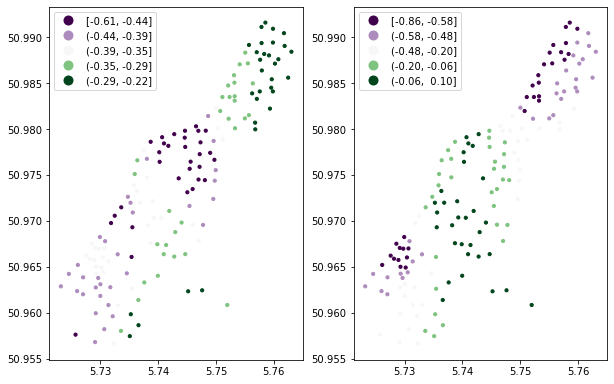

In [68]:
# Map coefficients
fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (10, 7))
meuse.plot(column='elev_params_stand', scheme='Quantiles', k=5, markersize=10, cmap='PRGn', legend=True, ax=axes[0])
meuse.plot(column='dist_params_stand', scheme='Quantiles', k=5, markersize=10, cmap='PRGn', legend=True, ax=axes[1])
plt.show()
fig.savefig(r'C:\Users\Rania\Desktop\UW\3.Research\SA_ML_xiaojian\Meuse_coeff.png')

<AxesSubplot:>

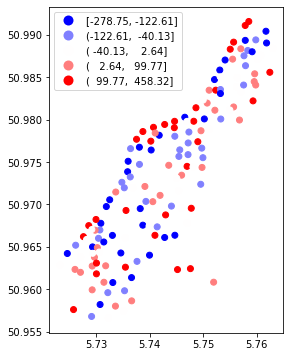

In [19]:
# Global Spatial Autocorrelation
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'aspect':'equal'})
meuse.plot(column='res', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

In [21]:
# The following part creates a spatial weights matrix (wq),
# and based on this the spatial lag operator of the residuals is created too.

wq =  ps.weights.KNN.from_dataframe(meuse, k=5) # this need to be the same like in the other expriments!
wq.transform = 'r'
y = meuse['res']
lag_res = ps.weights.lag_spatial(wq,y )

In [ ]:
# Calculate Moran's I

mi = esda.Moran(y, wq, permutations = 1000, two_tailed=False)
#print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)


In [25]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wq)

In [26]:
# Calculate spatial groupings and significance
meuse['Is'] = lisa.Is
meuse['pvalue'] = lisa.p_sim 
meuse['group'] = lisa.q 

meuse.loc[meuse['pvalue'] > 0.05, 'group'] = 'not-significant'
meuse.loc[meuse['group'] == 1, 'group'] = 'hotspot'
meuse.loc[meuse['group'] == 2, 'group'] = 'cold outlier'
meuse.loc[meuse['group'] == 3, 'group'] = 'coldspot'
meuse.loc[meuse['group'] == 4, 'group'] = 'hot outlier'

print(meuse ['group'].value_counts())

meuse.head(2)

not-significant    139
cold outlier         5
coldspot             4
hotspot              4
hot outlier          3
Name: group, dtype: int64


,zinc,elev,dist,om,POINT_X,POINT_Y,geometry,res,elev_params,elev_t,dist_params,dist_t,om_params,om_t,Is,pvalue,group
0,1022,7.909,0.001358,13.6,5.758534,50.991562,POINT (5.75853 50.99156),222.930353,-82.939539,0.0,-1123.200082,-4.965261,21.467804,0.0,-0.623202,0.224,not-significant
1,1141,6.983,0.012224,14.0,5.757861,50.991088,POINT (5.75786 50.99109),267.195191,-84.860293,0.0,-1137.006910,-5.046980,20.829683,0.0,-0.126997,0.491,not-significant


In [28]:
meuse.to_csv(r'...', index=False)

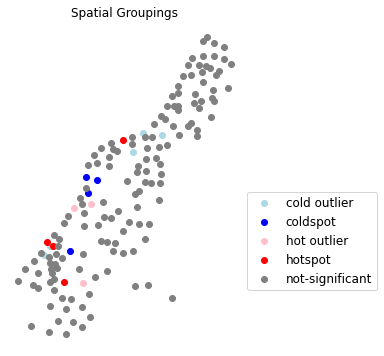

In [29]:
# Vizualize spatial groupings and significance
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}
group_colors

for ctype, data in meuse.groupby('group'):
    
    # Define the color for each group using the dictionary
    color = group_colors[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Spatial Groupings')

ax.set_axis_off()
plt.show()
